# Assignment 4 

In this assignment you will use all three topics covered in the unit, to simulate a type of particle detector known as a drift chamber.

Each part of the assignment can be completed separately, other than the final one where the individual pieces are drawn together. Each part includes necessary background information, followed by some instructions about how to write the code.  Please play particular attention to these sections.

You are expected to use numpy and scipy libraries wherever possible. You will not gain extra marks for writing your own implementation of routines that can be found in numpy/scipy.

The assignment is deliberately open ended, and there are a wide range of extensions that you can explore if you wish - please discuss with your demonstrator or the unit director.

## Introduction - The Drift Chamber

The drift chamber is a type of gas detector used to detect ionising radiation.  It is a variant of the "multi-wire proportional chamber", which was invented by Georges Charpak in 1968, and for which he won the Nobel Prize in 1992.

The basic device is a chamber containing an array of anode wires, as shown in the figure below.  The wires are held at a high voltage with respect to a cathode plate on the other side of the chamber. The chamber is filled with a gas (or sometimes a liquid).  When an ionising particle enters the chamber, it will ionise the gas, producing electrons and positive ions.  The electrons will drift in the electric field, until they reach a wire, which produces a signal that can be measured. By using an array of wires, and precisely recording the time at which a signal arrives, the position of the initial charge can be reconstructed in 2D.  The positive charge will also drift onto the cathode plate, but in this type of chamber, is not recorded.

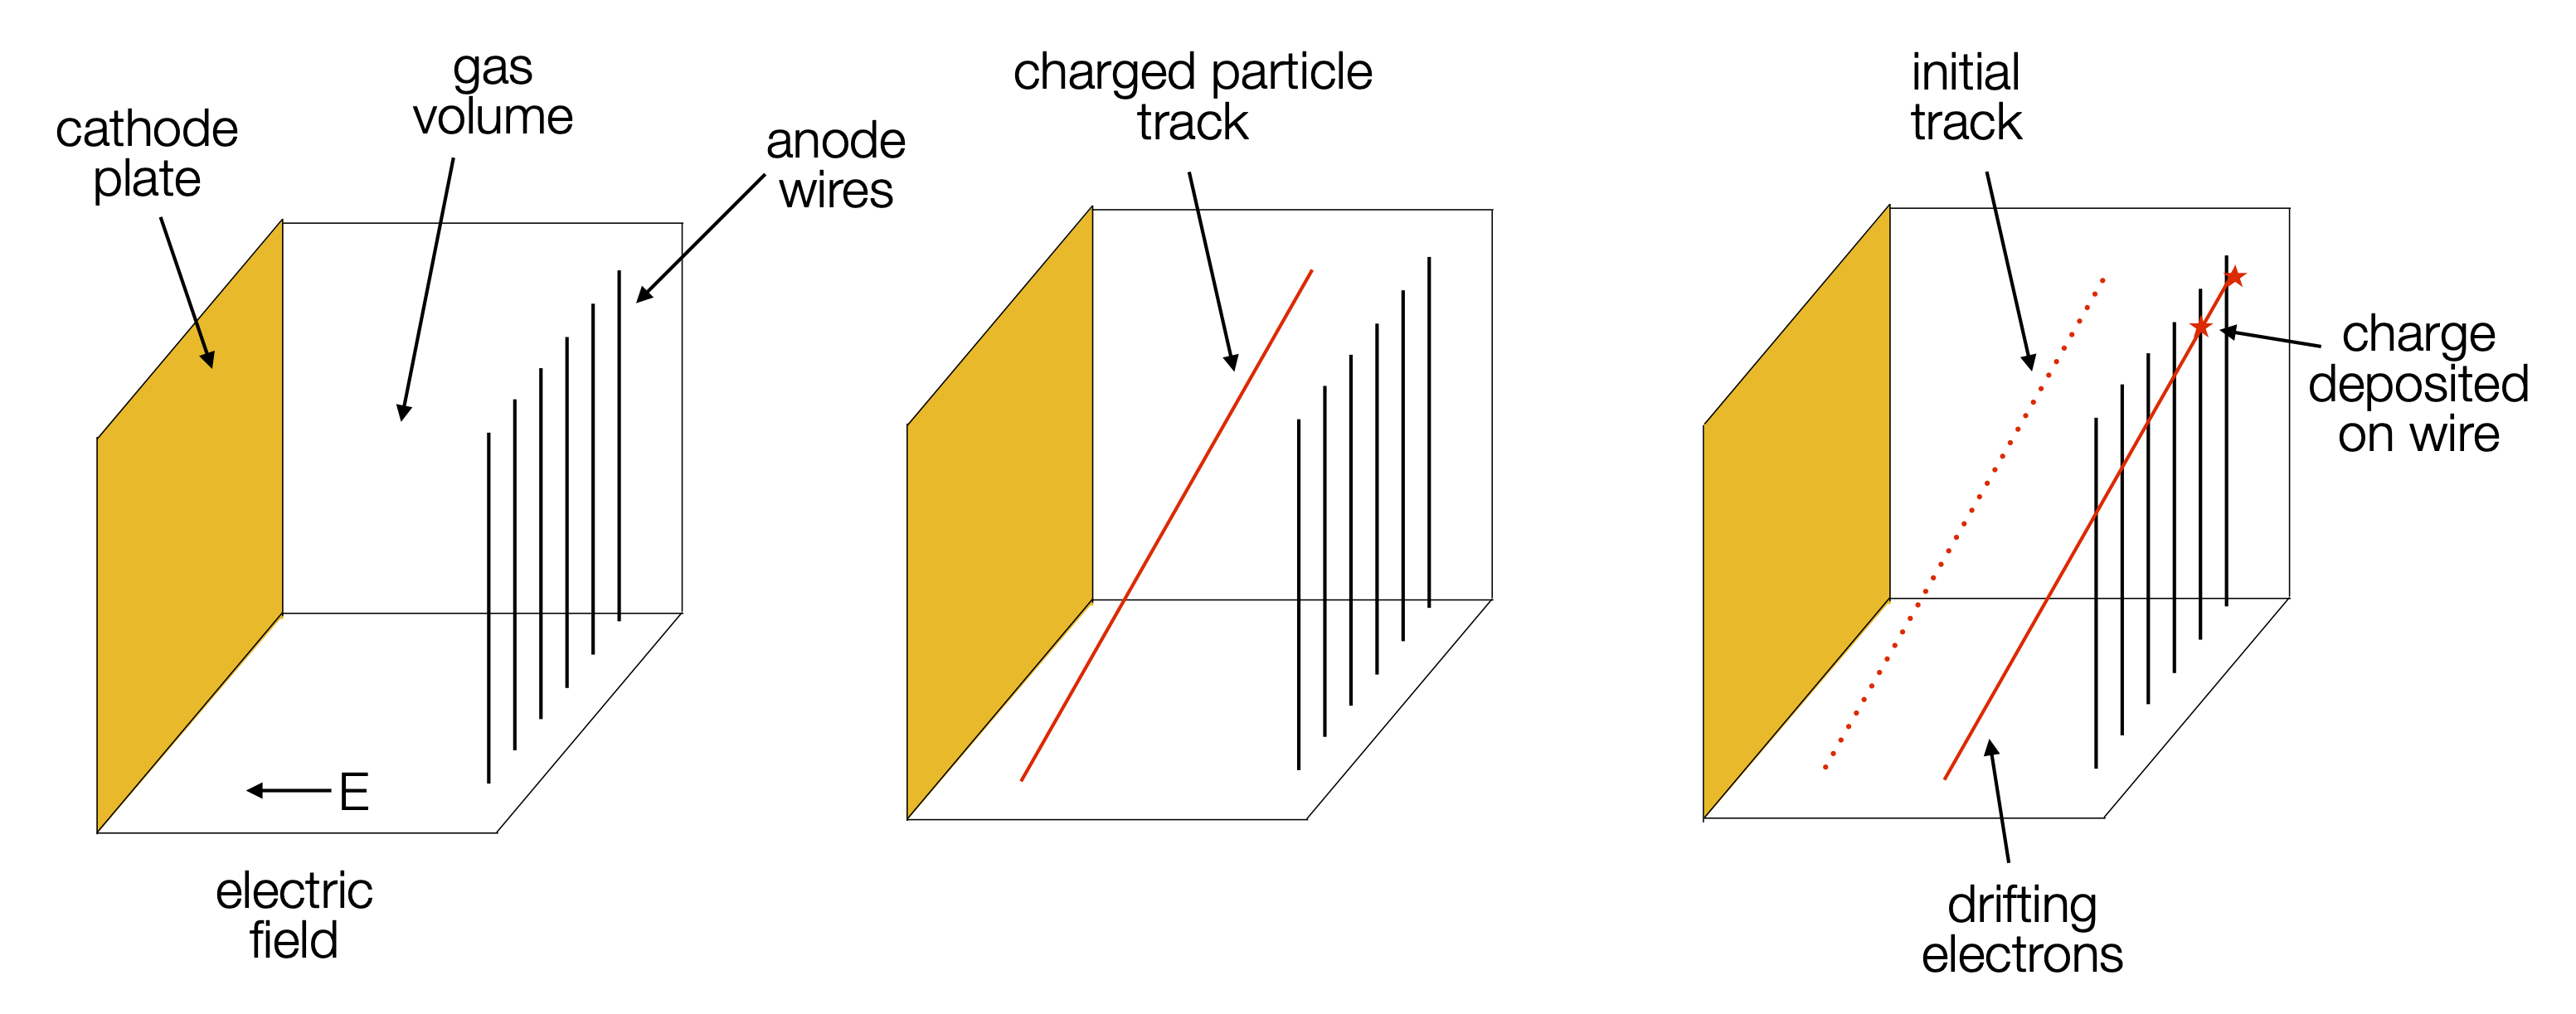

Below is an animation showing the operating principle of a drift chamber. (This particular chamber is a liquid Argon time-projection chamber, in which multiple arrays of wires are used to reconstruct the particle track in 3D.  However the principle is the same as the gaseous Ar detector we will simulate here).

<div>
    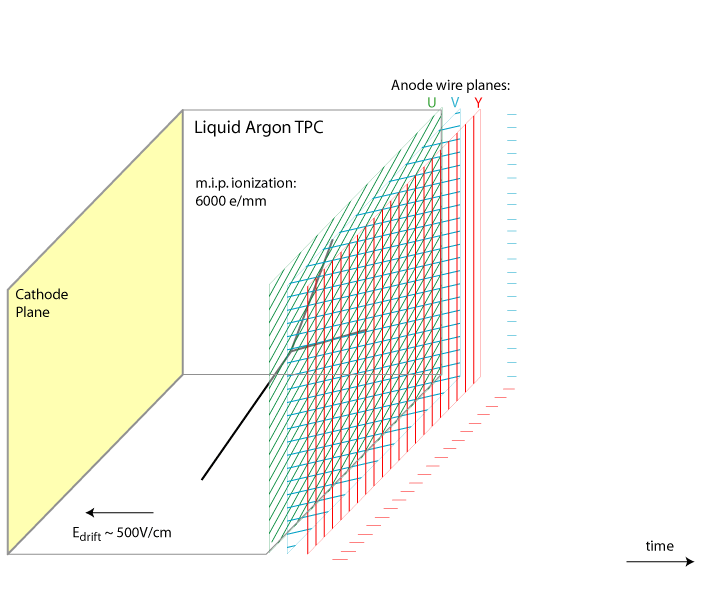
</div>

The particular setup you should simulate is shown in the figure below.

<div>
    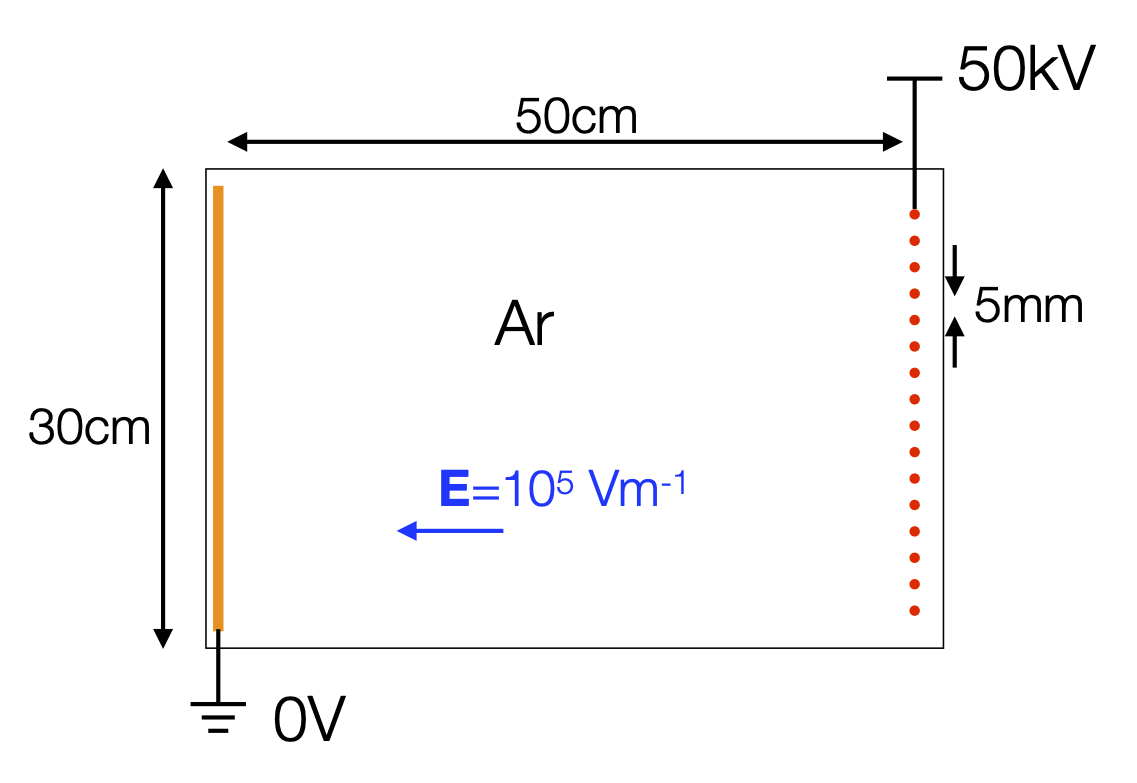
</div>

You can assume the Ar is at normal temperature and pressure (NTP : 293 K, 101 kPa), with electron diffusivity $D = 0.1 \: {\rm m^2s^{-1}}$, electron mobility $\mu=50 \: {\rm m^2V^{-1}s^{-1}}$, and total ionisation (for a cosmic ray muon) of $N_t = 9.4\times10^3$ electrons ${\rm m^{-1}}$. THe electric field within the chamber is $E=10^5 \: {\rm Vm}^{-1}$.

For parts 2-4 we will need to model the distribution of charge in the detector using a discrete grid.  It is suggested you start with a grid spacing of 0.1cm, which will allow your code to execute reasonably quickly.  Once your code is running, you may wish to decrease the grid spacing.

## Part 1 - Cosmic Ray Generation

In order to simulate the response of the detector, we need a simulation of the incoming particles. Here we will consider cosmic rays, which we will simulate using a Monte Carlo method.

At the Earth's surface, cosmic rays are essential all muons.  To a good approximation, they have a distribution in zenith angle $\theta$ which is proportional to ${\rm cos}^2(\theta)$, and are uniform in azimuthal angle $\phi$. We can assume they are uniformly distributed in the horizontal plane.

If the energy of the cosmic muon needs to be modelled, the distribution can be very crudely approximated in units of GeV/C by a log-normal distribution with $\mu=6.55$ and $\sigma=1.8$.  If the charge needs to be modelled, cosmic rays at the Earth's surface comprise approximately 30% more $\mu^+$ than $\mu^-$.

### Writing the code

Write a function that will randomly generate a cosmic ray muon each time it is called.  The function should return at least a direction in 3D, given the above distributions, as well as a starting position on a user definable horizontal plane.  Show that your function produces the desired distributions, at least qualitatively, by calling it for a large number of trials.

In [16]:
import numpy as np
import numpy.random as rnd
import scipy.stats as stats
import matplotlib.pyplot as plt

def CosmicRay():
    """Produce a randomly generated cosmic ray with position, direction, energy and charge."""
    
    #Random Positional values
    x = rnd.uniform(-60,60)
    y = rnd.uniform(-35,35)
    z = 30
    
    #Phi is azimuthal angle
    phi = rnd.uniform(0,2*np.pi)
    #theta is angle with z axis
    theta = (stats.cosine.rvs())**2
    
    energy = rnd.lognormal(6.55,1.8)
    charge = rnd.choice([-1,1],p=[0.43,0.57])
    
    position = [x,y,z]
    r = np.sqrt(x**2+y**2+z**2)
    direction = [r,np.pi-theta,phi]
    return position, direction, energy, charge

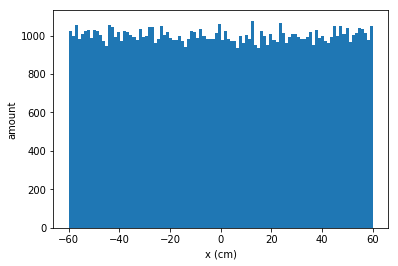

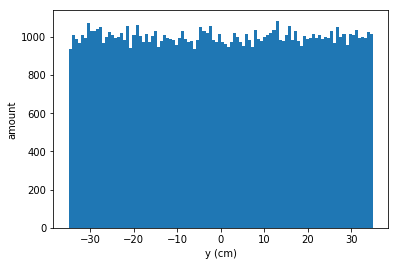

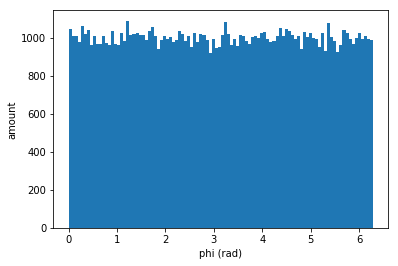

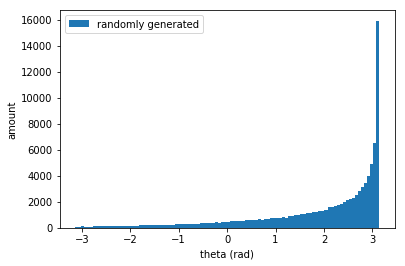

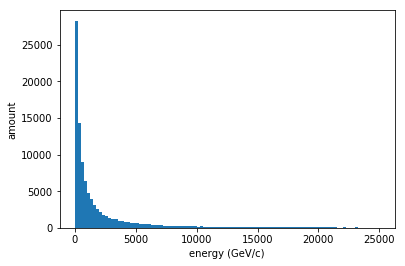

-1: 43275
+1: 56725


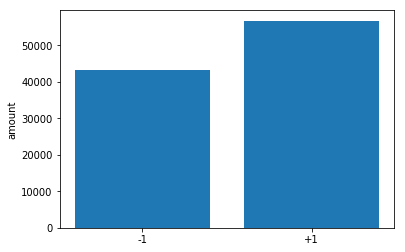

In [149]:
# write some code here to test the function above
x = []
y = []
phi = []
theta = []
energy = []
charge = []

#produce i cosmic rays
for i in range(100000):
    pos, direc, E, Q = CosmicRay()
    x.append(pos[0])
    y.append(pos[1])
    phi.append(direc[2])
    theta.append(direc[1])
    energy.append(E)
    charge.append(Q)
    
plt.hist(x,100)
plt.xlabel('x (cm)')
plt.ylabel('amount')
plt.show()

plt.hist(y,100)
plt.xlabel('y (cm)')
plt.ylabel('amount')
plt.show()

plt.hist(phi,100)
plt.xlabel('phi (rad)')
plt.ylabel('amount')
plt.show()

plt.hist(theta,100,[-np.pi,np.pi],label='randomly generated')
plt.xlabel('theta (rad)')
plt.ylabel('amount')
plt.legend()
plt.show()

plt.hist(energy,100,[0,25e3])
plt.xlabel('energy (GeV/c)')
plt.ylabel('amount')
plt.show()

minus = 0
plus = 0
for i in range(len(charge)):
    if charge[i] == -1:
        minus += 1
    elif charge[i] == 1:
        plus += 1
print('-1:',minus)
print('+1:',plus)
plt.bar(['-1','+1'],[minus,plus])
plt.ylabel('amount')
plt.show()

**Describe your code and results in this markdown cell**
I have generated x and y values that are to be distributed as uniformly as possible between the specified ranges.
Also the angle phi in the x-y plane is also uniform.
This is shown in the 1st three graphs with approximately 1000 across the whole range.

The angle theta is proportional to cosine^2 which I used a scipy.stats function to produce random variables for. This is shown in the graph as subtracted from pi radians as the cosmic rays will be pointing in the -z direction.

The energy is randomly generated according to a log-normal distribution and is also shown.

The charge of the cosmic muon is also randomly generated as being positive or negative. 
43,275x1.3 = 56,258 which gives a difference of 467. So it closely matches the probability given above.

## Part 2 - Ionisation

When a charged particle, such as a cosmic ray muon, traverses the wire chamber, it will ionise gas molecules. In order to model this ionisation, we can assume the muon loses negligible energy while traversing the detector, and liberates a fixed number of electrons per unit distance. For the Ar in the drift chamber we are modelling, you can assume 94 electrons are liberated per cm.  (A more sophisticated extension would use a Monte Carlo method to model variations in the number of liberated electrons as the muon traverses the chamber.)

### Writing the code

You should write a function which takes the starting position and direction of a randomly generated cosmic ray as input, and returns a 2D array representing the initial ionisation caused by the cosmic ray.  In order to achieve this, you may wish to first write a function which calculates the length of a track traversing a grid cell, given the track parameters and grid cell location. You should test your code by generating a few cosmic rays and plotting the resulting charge distribution.

In [60]:
import math

def Path(pos,direc):
    """Using starting position and direction returns path through the detector."""
    
    #convert direction to cartesian coordinates
    direc = [np.sin(direc[1])*np.cos(direc[2]), np.sin(direc[1])*np.sin(direc[2]), np.cos(direc[1])]
    start = [pos[0],pos[2]]
    
    grad = direc[2]/direc[0]
    c = start[1] - grad*start[0]
    
    if start[1] > 30:
        return 0,0,0
    
    #change the starting location to the side of the box
    if start[0] < -25:
        start = [-25,grad*(-25)+c]
        
        if -c/grad < 25 and -c/grad >= -25:
            end = [-c/grad,0]
        elif -c/grad >= 25:
            end = [25,grad*(25)+c]
        else:
            return 0,0,0
        
    elif start[0] > 25:
        start = [25,grad*(25)+c]
    
        if -c/grad > -25 and -c/grad <= 25:
            end = [-c/grad,0]
        elif -c/grad <= -25:
            end = [-25,grad*(-25)+c]
        else:
            return 0,0,0
           
    else:
        if -c/grad <= -25:
            end = [-25,grad*(-25)+c]
        elif -c/grad >= 25:
            end = [25,grad*(25)+c]
        else:
            end = [-c/grad,0]
    
    return start, end, grad

def Charge(h):
    """Assigns charge values to each grid location based on path length."""
    
    start = 0
    while start == 0:
        pos, direc, E, Q = CosmicRay()
        start, end, grad = Path(pos,direc)
    
    cells = np.zeros((int(50/h),int(30/h)))
    
    start_cell = [math.floor((25+start[0])/h),math.floor(start[1]/h)]
    end_cell = [math.floor((25+end[0])/h),math.floor(end[1]/h)]
    
    x_0 = (25+start[0])/h -start_cell[0]
    z_0 = (start[1])/h -start_cell[1] 
    
    if end_cell[0] == int(50/h):
        end_cell[0] = int(50/h)-1
    
    #loop over each cell
    #check if at end
    #length of path in cell
    #end point in cell will specify the next cell
    
    i = start_cell[0]
    j = start_cell[1]
    
    
    #if somehow they are both randomly integers
    if type(x_0) == int and grad > 0 and j == int(30/h):
        i -= 1
        x_0 = 1            
        
    #if starting beyond box 50
    if start_cell[0] == int(50/h):
        x_0 = 1
        i -= 1
        
    #if starting at z = 30
    elif z_0 == 0 and j == int(30/h):
        j -= 1
        z_0 = 1
    
    finish = False
    while finish == False:
        
        i0 = i
        j0 = j
            
        #when path starts left
        if x_0 == 0:
                
            #right
            if z_0-grad*(x_0-1) > 0:
                z_1 = z_0 - grad*(x_0-1)
                x_1 = 1
                i += 1
                
            #bottom
            elif -z_0/grad + x_0 < 1:
                z_1 = 0
                x_1 = -z_0/grad + x_0
                j -= 1
                
        #when paths starts right    
        elif x_0 == 1:
                
            #left
            if z_0-grad*x_0 > 0:
                x_1 = 0
                z_1 = z_0-grad*x_0
                i -=1
                    
            #bottom
            elif -z_0/grad + x_0 > 0:
                z_1 = 0
                x_1 = -z_0/grad + x_0
                j -= 1
            
        #when path starts top
        elif z_0 == 1:
                
            #right
            if z_0-grad*(x_0-1) > 0 and grad < 0:
                z_1 = z_0 - grad*(x_0-1)
                x_1 = 1
                i += 1
                    
            #left
            elif z_0-grad*x_0 > 0 and grad > 0:
                x_1 = 0
                z_1 = z_0-grad*x_0
                i -=1
                    
            #bottom
            elif -z_0/grad + x_0 > 0 and -z_0/grad < 1:
                z_1 = 0
                x_1 = -z_0/grad + x_0
                j -= 1
                    
        #calculate path length
        length = np.sqrt((x_1-x_0)**2+(z_1-z_0)**2)
        cells[i0][j0] = length*94
        #distance travelled in y
        deltaz = abs(z_1-z_0)
        dydz = direc[1]/direc[2]
        y_dist = deltaz*dydz
        length = np.sqrt(length**2+y_dist**2)
            
        #check if at end
        if i0 == end_cell[0] and j0 == end_cell[1]:
            finish = True
            
        #update x_0 and z_0 for next loop
        if x_1 == 0:
            x_0 = 1
            z_0 = z_1
        elif x_1 == 1:
            x_0 = 0
            z_0 = z_1
        elif z_1 == 0:
            z_0 = 1
            x_0 = x_1
        
    return cells

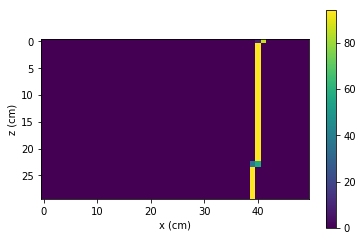

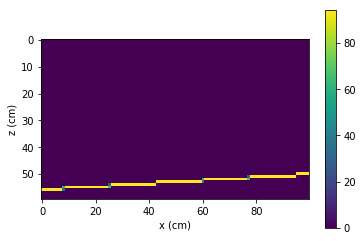

In [104]:
# write some code here to test the above function
q = Charge(1)
plt.imshow(q.T)
plt.colorbar()
plt.title('h = 1cm')
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.show()

q = Charge(0.5)
plt.imshow(q.T)
plt.title('h = 0.1cm')
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.colorbar()
plt.show()

**Describe your code and results in this markdown cell**

The Path function takes the starting position and direction then calculates the end position.
Then the charge function generates a random cosmic ray which enters the detector. It cycles over every single grid which the  ray passes through and the distanced travelled within each grid cell determines the charge deposited. This is done using the gradient of the ray and start/end positions within the cell. The start position is determined from where the ray exits the previous cell.

The produced grid is shown above with the grid spacing h set to 1cm and 0.1cm. 
The cosmic rays are produced along the line z = 30cm for the top graph. The charge deposited in each cell is at a maximum when the ray passes through opposite sides of the grid cells which is what was expected.

# Part 3 - Drift-Diffusion

The charge produced by ionisation will drift towards the anode wires, where it can be detected.  However, it will also diffuse in the gas.  These two 'transport' processes are described by the drift-diffusion equation  :

$$\frac{\partial q}{\partial t} = D \nabla^2 q - \frac{1}{\mu} {\bf E} \cdot (\nabla q)$$

Here, $q(x,y)$ represents the charge distribution in 2D.  The first term on the RHS represents diffusion, the second represents the charge drift under the influence of the electric field.

By expanding in terms of (x,y) this can be written :

$$\frac{\partial q}{\partial t} = D\frac{\partial^2 q}{\partial x^2} + D\frac{\partial^2 q}{\partial y^2} - \frac{E_x}{\mu}\frac{\partial q}{\partial x} - \frac{E_x}{\mu}\frac{\partial q}{\partial y}$$

For the diffusion terms, we will use the same implicit finite difference scheme described in lectures and the previous assignment, but expanded to 2D.  For the drift terms, we will use the 1st order backward difference, also known as the "upwind" scheme (since the backward difference is "upwind" of the electrostatic force direction).  There are other choices (eg. the 2nd order centred difference) but these are prone to non-physical oscillations.

The full finite difference equation is then :

$$\frac{q^{n+1}_{i,j} - q^n_{i,j}}{\tau} = D\frac{q^{n+1}_{i-1,j} - 2q^{n+1}_{i,j} + q^{n+1}_{i+1,j}}{h^2} + D\frac{q^{n+1}_{i,j-1} - 2q^{n+1}_{i,j} + q^{n+1}_{i,j+1}}{h^2} - \frac{E_x}{\mu}\frac{(q^{n+1}_{i,j}- q^{n+1}_{i-1,j})}{2h} - \frac{E_y}{\mu}\frac{(q^{n+1}_{i,j}-q^{n+1}_{i,j-1})}{2h}$$

But we can simplify this by assuming the electric field is uniform and non-zero in the x-direction only :

$$q^n_{i,j} = - \alpha q^{n+1}_{i-1,j} - \alpha q^{n+1}_{i+1,j} - \alpha q^{n+1}_{i,j-1} - \alpha q^{n+1}_{i,j+1} + (1+4\alpha) q^{n+1}_{i,j} - \beta q^{n+1}_{i-1,j} + \beta q^{n+1}_{i,j}$$

where $\alpha = \frac{D \tau}{h^2}$ and $\beta = \frac{\tau E}{2\mu h}$.

Or collecting terms relating to the same node :
$$q^n_{i,j} = ( - \alpha- \beta) q^{n+1}_{i-1,j} - \alpha q^{n+1}_{i+1,j} - \alpha q^{n+1}_{i,j-1} - \alpha q^{n+1}_{i,j+1} + (1+4\alpha+\beta) q^{n+1}_{i,j}$$

This is an implicit equation, expressing $q^n$ in terms of $q^{n+1}$ for a node and its neighbours. Just as for the 1D diffusion problem, we will need to solve the equation for each timestep, and iterate.

And again just like the 1D diffusion problem, we can represent this finite difference equation as a matrix.  However, there is an added complication because we now have a 2D grid.  What we have to do is represent each node in the 2D grid systematically as a row (or column) of the matrix.  This means if we have a grid of size $n_i \times n_j$, the matrix will need to be $n_i n_j \times n_i n_j$.  One way of systematically mapping nodes onto rows/columns of the matrix is to use "row-major ordering", where the matrix index $k$ corresponding to grid node $(i,j)$ is $k = n_ij + i$.

Assuming the 2D grid is stored in a row-major ordered vector, then we can write the finite difference equation as a matrix equation :
$$q^n = M q^{n+1}$$

For a small example, if $n_i=n_j=4$, then matrix M is $16 \times 16$ and its top-left quadrant ($8 \times 8$) is  :

$$M = \pmatrix{
1+4\alpha+\beta & -\alpha &  &  & -\alpha  &  &  &  & \\
-\alpha-\beta & 1+4\alpha+\beta & -\alpha &  &  & -\alpha &  &  & \\
 & -\alpha-\beta & 1+4\alpha+\beta & -\alpha &  &  & -\alpha &  & \\
 &  & -\alpha-\beta & 1+4\alpha+\beta & -\alpha &  &  & -\alpha & \\
-\alpha &  &  & -\alpha-\beta & 1+4\alpha+\beta & -\alpha &  &  & \\  
  & -\alpha &  &  & -\alpha-\beta & 1+4\alpha+\beta & -\alpha &  & \\  
  &  & -\alpha &  &  & -\alpha-\beta & 1+4\alpha+\beta & -\alpha & \\
  &  &  & -\alpha &  &  & -\alpha-\beta & 1+4\alpha+\beta & \\
}$$

And the diagonals continue into the remaining quadrants.  This is a "tri-diagonal matrix with fringes".  It comprises five diagonal elements corresponding to the five terms in the previous equation.  The tri-diagonal part corresponds to the terms for $(i-1, j)$, $(i,j)$ and $(i+1, j)$ while the fringes are the terms for $(i, j-1)$ and $(i, j+1)$.  In terms of the matrix coordinate $k$, the fringe diagonals start at $(0,n_i)$ and $(n_i,0)$.

In the absence of additional terms, the matrix equation above possesses a "periodic boundary condition".  Effectively, this means any charge leaving the grid on one edge will re-appear on the opposite edge, which is adequate for our purposes here.

### Writing the code

Solving the 2D drift-diffusion equation is conceptually similar to the 1D diffusion equatino you have already encountered.  The differences are : the changes needed to handle a 2D grid of nodes, and the $\beta$ term in the matrix M to accomodate charge drift.

First you will need to write a function that will create the matrix M. You should verify that this function produces the desired matrix for a simple test case.

Next,  write a function which iteratively solves the matrix equation $q^n = M q^{n+1}$ for each timestep, using an appropriate routine from scipy.  This function should take a 2D array of the charge distribtuion as input. However, you will need to convert this to a 1D array in order to solve the matrix equation.  **Hint** : You can use `ndarray.flatten()` to convert a 2D array into a row-major ordered 1D array, and you can use `ndarray.reshape(ny, nx)` to convert a 1D row-major ordered array back into a 2D array.

You should test your code with a simple test case, eg. an initial point charge.  You may wish to also examine the behaviour under 'diffusion only' and 'drift only' conditions, ie. with E or D set to zero.

As stated in the introduction, for Argon at NTP you can assume $D=0.1$, $\mu=50 \: {\rm m^2V^{-1}s^{-1}}$ and $E=10^5 \: {\rm Vm}^{-1}$. Given these values, an appropriate run time is $\mathcal{O}(10^{-4}) \: {\rm s}$.    

In [113]:
# write a function here to generate the drift-diffusion matrix M
def setup_matrix(tau,h,n_x,n_z,D,E):
        """Setup for the values of the rod"""
        #Parameters
        if D != 0 and D != 1000:
            D = 0.1
        mu = 50
        if E != 0:
            E = 1e5
        
        alpha = (D*tau)/h**2
        beta = (tau*E)/(2*mu*h)
        
        #Matrix setup M
        M = np.zeros((n_x*n_z,n_x*n_z))
        for i in range(n_x*n_z):
            for j in range(n_x*n_z):
                if i == j:
                    M[i][j] = 1 + 4*alpha + beta
                elif j == i+1 or j == i-1:
                    M[i][j] = -1*alpha
                elif j == i+n_z:
                    M[i][j] = -1*alpha
                elif j == i-n_z:
                    M[i][j] = -alpha - beta
                    
        return M

In [114]:
# write a function here to test it
n_x = 4 
n_z = 4
h = 1
tau = 0.01
M = setup_matrix(tau,h,n_x,n_z,7,7)
matrix = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        matrix[i][j] = M[i][j]
print(matrix)

[[ 1.1004e+01 -1.0000e-03  0.0000e+00  0.0000e+00 -1.0000e-03  0.0000e+00]
 [-1.0000e-03  1.1004e+01 -1.0000e-03  0.0000e+00  0.0000e+00 -1.0000e-03]
 [ 0.0000e+00 -1.0000e-03  1.1004e+01 -1.0000e-03  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00 -1.0000e-03  1.1004e+01 -1.0000e-03  0.0000e+00]
 [-1.0001e+01  0.0000e+00  0.0000e+00 -1.0000e-03  1.1004e+01 -1.0000e-03]
 [ 0.0000e+00 -1.0001e+01  0.0000e+00  0.0000e+00 -1.0000e-03  1.1004e+01]]


In [121]:
# write a function here to iteratively solve the matrix equation for specified number of timesteps
import scipy.linalg as linalg
def fde(M,q):
    """Apply the inplicit finite difference method equation"""
    #q(t+1) = M^-1@q(t)
    
    q = np.array(q)
    q_0 = q.flatten()
    
    q_1 = linalg.inv(M) @ q_0
    q = q_1.reshape(50,30)
    return q

def runSOR(q,M,omega,atol,tmax):
    """Implement successive-over-relaxation"""
    
    #keeps track of the iteration number t
    for t in range(tmax+1) :
        #print(t)
        
        dmax = 0.
        u = fde(M,q)
        
        #goes over every node in q then updates it
        for i in range(q.shape[0]):
            for j in range(q.shape[1]):
            
                old = q[i][j]
                new = u[i][j]
                d = new - old
                
                if abs(d) > dmax:
                    dmax=abs(d)
                        
                q[i][j] = old+omega*d
        
        # test for convergence
        if dmax<atol:
            print('tolerance reached')
            return q, t, dmax
    
    print('max time reached')
    return q, t, dmax

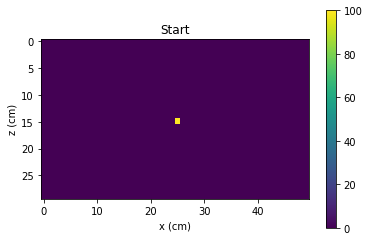

max time reached


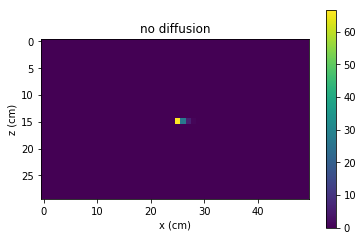

final time: 0.0004 s
tolerance reached


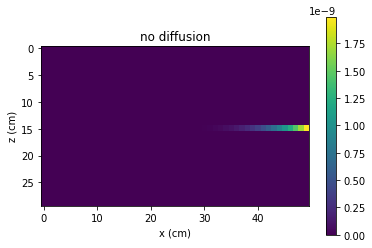

final time: 4 s
max time reached


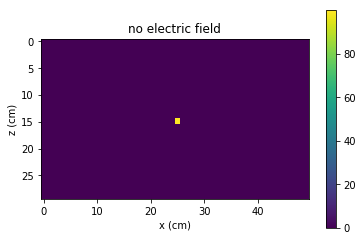

final time: 0.0004 s
max time reached


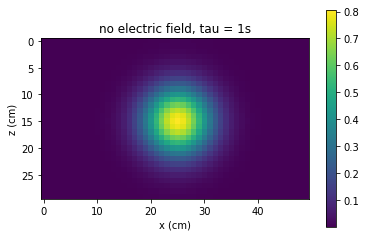

final time: 100 s


In [144]:
# write some code here to test the functions above
n_x = 50 
n_z = 30
h = 1
tau = 0.00001

q = np.zeros((n_x,n_z))
q[25][15] = 100

plt.imshow(q.T)
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.title('Start')
plt.colorbar()
plt.show()

#D=0 until 0.0001s
M = setup_matrix(tau,h,n_x,n_z,0,7)
u, t, dmax = runSOR(q,M,omega=1,atol=0.000001,tmax=int(0.0004/tau))
plt.imshow(u.T)
plt.title('no diffusion')
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.colorbar()
plt.show()
print('final time:',t*tau,'s')

#D=0 until hits wall
q = np.zeros((n_x,n_z))
q[25][15] = 100
tau = 1
M = setup_matrix(tau,h,n_x,n_z,0,7)
u, t, dmax = runSOR(q,M,omega=1,atol=0.00001,tmax=1000)
plt.imshow(u.T)
plt.title('no diffusion')
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.colorbar()
plt.show()
print('final time:',t*tau,'s')

#E=0 until 0.0001s
q = np.zeros((n_x,n_z))
q[25][15] = 100
tau = 0.00001
M = setup_matrix(tau,h,n_x,n_z,7,0)
v, t, dmax = runSOR(q,M,omega=1,atol=0.000001,tmax=int(0.0004/tau))
plt.imshow(v.T)
plt.title('no electric field')
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.colorbar()
plt.show()
print('final time:',t*tau,'s')

#E=0 until can see it
q = np.zeros((n_x,n_z))
q[25][15] = 100
tau = 1
M = setup_matrix(tau,h,n_x,n_z,7,0)
v, t, dmax = runSOR(q,M,omega=1,atol=0.000001,tmax=int(100/tau))
plt.imshow(v.T)
plt.title('no electric field, tau = 1s')
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.colorbar()
plt.show()
print('final time:',t*tau,'s')

My matrix M is different to that given in the assignment and I have instead used the flipped orientation to keep all of my indexing consistent. Above I have printed the top left 6x6 corner of the matrix which clearly shows the correct diagonals for n_x=n_z=4.

I have used scipy.linalg.inv() to solve the matrix equation for each step. Then I used succesive-over relaxation to see when it reaches a final state.

To show test it I have used a point charge in the centre of the chamber.
With D=0 it is clear that the charge drifts to the right as expected. If the charge is left it will eventually reach the wires on the right side of the detector.
With E=0 it is not clear if the charge has diffused out on the same timescale as for the graphs with no diffusion so I have also produced a graph with a larger value of tau that runs for longer. This results in move visible diffusion effects showing that the functions are working.

The fact that the diffusion effects aren't as prominent on the same timescale as the electric field will mean that it is not going to make a huge difference in the graphs for part 4.

# Part 4 - Simulating the Drift Chamber

Now use the functions you have defined above to simulate the full process :
* a cosmic muon entering the drift chamber
* the initial charge distribution resulting from that cosmic muon
* the charge drifting, and diffusing, under the influence of the electric field

Run these steps for at least one cosmic ray muon, and plot the results in an appropriate format.

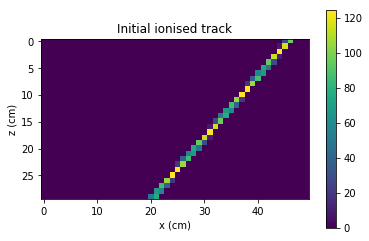

max time reached


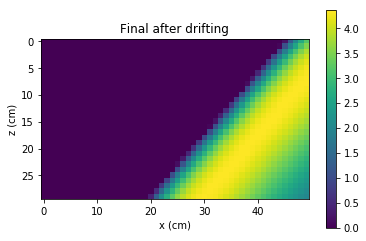

final time: 0.01 s


In [154]:
# run functions from parts 1-3 here to simulate the passage of a cosmic ray through the detector and subsequnet charge drift
h = 1
tau = 0.01
n_x = 50
n_z = 30
M = setup_matrix(tau,h,n_x,n_z,7,7)
q = Charge(h)

#starting graph
plt.imshow(q.T)
plt.title('Initial ionised track')
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.colorbar()
plt.show()

q, t, dmax = runSOR(q,M,omega=1,atol=0.000001,tmax=1)

#graph after drift
plt.imshow(q.T)
plt.title('Final after drifting')
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.colorbar()
plt.show()
print('final time:',t*tau,'s')

**Describe your code and results in this markdown cell**

Here a cosmic ray is produced according to the random number generation in part 1. 
It ionises the gas producing the electrons which have an initial distribution shown in the 1st graphs.
The electrons then drift and diffuse towards the wires at x = 50cm.

The operation of the drift chamber is clearly shown when the muon path is at an angle. After t=0.01s above the top part of the track has reach the detection wires whereas the bottom has not. Using how long the electronic signal took to be recieved the path of the muon can be reconstructed.

The graph also shows that as the charge drifts the electronic distribution spreads out due to the electric field and diffusion. This could make it more difficult to tell exactly how long the charge took to reach the wires.